In [2]:
%load_ext autoreload
%autoreload 2

import os
if not 'DISPLAY' in os.environ:
    os.environ['DISPLAY'] = ':1'

import numpy as np
from skimage import io
from dm_control.suite import common

from genome_synth import Physics, Genesis, Avoid
from dm_control import mujoco
from dm_control.rl import control
from dm_control.rl.control import PhysicsError

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
from xml.etree import ElementTree as ET

class DummyGen(Genesis):
    def override_from_xml(self, xml_str):
        self.joints = set()
        spec = ET.fromstring(xml_str)
        for motor in spec.iter('motor'):
            if 'joint' in motor.attrib:
                self.joints.add(motor.attrib['joint'])


/home/studio/miniconda3/envs/py3k/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/studio/miniconda3/envs/py3k/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


BoundedArraySpec(shape=(24,), dtype=dtype('float64'), name=None, minimum=[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.], maximum=[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]) OrderedDict([('offset', ArraySpec(shape=(3,), dtype=dtype('float64'), name=None))])


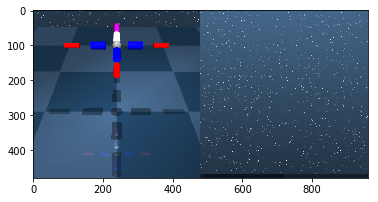

done


In [112]:
from deap import base, creator, gp, tools

gen = DummyGen()
pset = gp.PrimitiveSet("MAIN", 0)
pset.addPrimitive(gen.combine_trees, 2)
#pset.addEphemeralConstant("mk_leaf", gen.mk_leaf)
pset.addTerminal(gen.mk_leaf)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr_init", gp.genFull, pset=pset, min_=2, max_=4)

toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr_init)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

xml_name = './starfish.xml'

with open(xml_name) as starfishf:
    starfish_str = starfishf.read()
    
def capture():
    imnames = set()
    picidx = 0
    _DEFAULT_TIME_LIMIT = 10
    _CONTROL_TIMESTEP = .04
    display_stride = 1 / .04 // 24
    gen.override_from_xml(starfish_str)
    genesis_physics = Physics.from_xml_string(common.read_model(os.path.join(os.getcwd(), xml_name)), 
                                              common.ASSETS)
    genesis_physics.set_gen(gen)
    genesis_task = Avoid()
    genesis_env = control.Environment(genesis_physics, 
                                     genesis_task,
                                     control_timestep=_CONTROL_TIMESTEP,
                                     time_limit=_DEFAULT_TIME_LIMIT)
    action_spec = genesis_env.action_spec()
    observation_spec = genesis_env.observation_spec()
    print(action_spec, observation_spec)
    time_step = genesis_env.reset()
    curtime = 0.0
    top_view = genesis_env.physics.render(480, 480, camera_id='tracking_top')
    side_view = genesis_env.physics.render(480, 480, camera_id='arm_eye')
    plt.imshow(np.concatenate((top_view, side_view), axis=1))
    plt.pause(0.5)
    plt.show()
    did_except = False
    
    while(not time_step.last()):
        try:
            action = np.ones(action_spec.shape[0]) * (np.sin(curtime))
            action = np.sin(np.linspace(curtime, curtime + 3.14159, num=action_spec.shape[0]))
            time_step = genesis_env.step(action)
            savename = "/tmp/starfish_{0:04}.jpg".format(picidx)
            picidx += 1
            imnames.add(savename)
            curtime += _CONTROL_TIMESTEP
            top_view = genesis_env.physics.render(480, 480, camera_id='tracking_top')
            side_view = genesis_env.physics.render(480, 480, camera_id='arm_eye')
            #plt.imshow(np.concatenate((top_view, side_view), axis=1))
            #plt.pause(0.5)
            io.imsave(savename, np.concatenate((top_view, side_view), axis=1))
        except PhysicsError:
            print('except')
            did_except = True
            break
    if not did_except and os.path.isfile('starfish.mp4'):
        os.remove('starfish.mp4')
    if not did_except:
        !!ffmpeg -f image2 -pattern_type sequence -i "/tmp/starfish_%4d.jpg" -qscale:v 0 starfish.mp4
    for name in imnames:
        os.remove(name)
    print("done")
capture()

In [ ]:
starfish_arm = lambda path_so_far, depth: {
    'body': {
        'name': path_so_far + '.' + 'arm_segment' ,
        'pos':  '0.1 0.0 0.0',
        'children': [
            {'joint': {'axis': '1 0 0'}}
        ]
    }
} if depth >= 0 else None

starfish_dict = {
    'body': {'name': 'root', 'childclass': 'starfish', pos: '0 0 1'},
    
}

def dict_2_creature(num_arms, template_xml='starfish.xml'):
    joints = set()
    actuator = set()
    contact_excludes = set()
    
    